In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-propaganda-classification/twitter_dataset_translated_ukrainian.csv
/kaggle/input/twitter-propaganda-classification/twitter_dataset.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

from IPython.display import display, Markdown

2024-03-27 17:51:56.867344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 17:51:56.867503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 17:51:57.058126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
display(Markdown("**Full Dataset:**"))
data = pd.read_csv('/kaggle/input/twitter-propaganda-classification/twitter_dataset.csv')
display(data.head())
display("Full Dataset Shape: ", data.shape)

display(Markdown("**Clean (Non-Propagandistic) Text Dataset:**"))
clean_data = data[data['is_propaganda'] == False]
clean_data = clean_data[['text']]
display(clean_data.head())
display("Clean Text Dataset Shape: ",clean_data.shape)

display(Markdown("**Human Propaganda Dataset:**"))
human_propaganda = data[data['is_propaganda'] == True]
human_propaganda = human_propaganda[['text']]
display(human_propaganda.head())
display("Human Propaganda Text Dataset Shape: ",human_propaganda.shape)

**Full Dataset:**

,Unnamed: 0,id,created_at,text,is_propaganda
0,1749,1514553915580329988,2022-04-14 10:39:27+00:00,Woman who held up poster of Marine Le Pen and ...,False
1,2409,1510803460320632839,2022-04-04 02:16:28+00:00,"⚡️Zelensky: Around 150,000 people trapped in M...",False
2,2463,1475560113536741379,2021-12-27 20:12:00+00:00,RT @natomission_ru: 🇷🇺#Russia Deputy FM Sergey...,True
3,116,1527722359314075649,2022-05-20 18:46:08+00:00,#Azovstal fully liberated – Russian military\n...,True
4,2742,1517110124325879808,2022-04-21 11:56:54+00:00,"RT @BloombergUK: ""He was almost foaming at the...",False


'Full Dataset Shape: '

(12990, 5)

**Clean (Non-Propagandistic) Text Dataset:**

,text
0,Woman who held up poster of Marine Le Pen and ...
1,"⚡️Zelensky: Around 150,000 people trapped in M..."
4,"RT @BloombergUK: ""He was almost foaming at the..."
8,Key UN climate change finding widely misinterp...
10,Lawyers for the two European tourists argued m...


'Clean Text Dataset Shape: '

(6495, 1)

**Human Propaganda Dataset:**

,text
2,RT @natomission_ru: 🇷🇺#Russia Deputy FM Sergey...
3,#Azovstal fully liberated – Russian military\n...
5,'Intense battle' | Russian army surrounds last...
6,Russia’s FSB has released footage reportedly s...
7,"Hundreds of activists gathered in Washington, ..."


'Human Propaganda Text Dataset Shape: '

(6495, 1)

# Transformer Text Classification

In [5]:
import keras
from keras import ops
from keras import layers

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
display(Markdown("**Initial Dataset**"))
display(data.head())
df = data[['text', 'is_propaganda']]
display(Markdown("**Dataset for classification**"))
display(df)

**Initial Dataset**

,Unnamed: 0,id,created_at,text,is_propaganda
0,1749,1514553915580329988,2022-04-14 10:39:27+00:00,Woman who held up poster of Marine Le Pen and ...,False
1,2409,1510803460320632839,2022-04-04 02:16:28+00:00,"⚡️Zelensky: Around 150,000 people trapped in M...",False
2,2463,1475560113536741379,2021-12-27 20:12:00+00:00,RT @natomission_ru: 🇷🇺#Russia Deputy FM Sergey...,True
3,116,1527722359314075649,2022-05-20 18:46:08+00:00,#Azovstal fully liberated – Russian military\n...,True
4,2742,1517110124325879808,2022-04-21 11:56:54+00:00,"RT @BloombergUK: ""He was almost foaming at the...",False


**Dataset for classification**

,text,is_propaganda
0,Woman who held up poster of Marine Le Pen and ...,False
1,"⚡️Zelensky: Around 150,000 people trapped in M...",False
2,RT @natomission_ru: 🇷🇺#Russia Deputy FM Sergey...,True
3,#Azovstal fully liberated – Russian military\n...,True
4,"RT @BloombergUK: ""He was almost foaming at the...",False
...,...,...
12985,"""There is real genocide - what you have seen h...",False
12986,⚡️ Finland imported 70% less crude oil from Ru...,False
12987,Can Congress legalise abortion if Supreme Cour...,False
12988,"RT @mod_russia: In total 2,241 Russian and for...",True


In [7]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [8]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review

features = df['text']
labels = df['is_propaganda']

# Tokenize the text data
vocab_size = 10000  # Тhe size of your vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(features)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(features)

# Pad sequences to ensure uniform length
maxlen = 200  # Define the maximum length of sequences
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
print(len(x_test), "Testing sequences")

10392 Training sequences
1299 Validation sequences
1299 Testing sequences


In [10]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [11]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(60, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(40, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 32)        │       326,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,338 (1.31 MB)

 Trainable params: 342,338 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.4940 - loss: 0.6986 - val_accuracy: 0.5135 - val_loss: 0.6927
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.5123 - loss: 0.6933 - val_accuracy: 0.4865 - val_loss: 0.6914
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.7198 - loss: 0.5173 - val_accuracy: 0.8791 - val_loss: 0.2746
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.9392 - loss: 0.1747 - val_accuracy: 0.8814 - val_loss: 0.3006
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9715 - loss: 0.0875 - val_accuracy: 0.8668 - val_loss: 0.3187
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.9864 - loss: 0.0507 - val_accuracy: 0.8722 - val_loss: 0.3970
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.9939 - loss: 0.0269 - val_accuracy: 0.8768 - val_loss: 0.6403
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9971 - loss: 0.0119 - 

In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8614 - loss: 1.9845
Test Loss: 1.6730022430419922
Test Accuracy: 0.8791378140449524


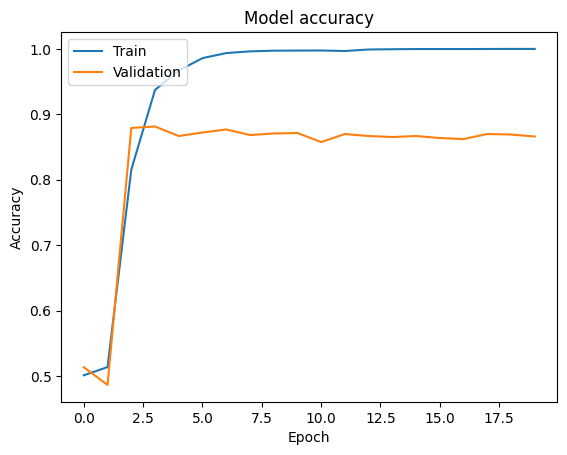

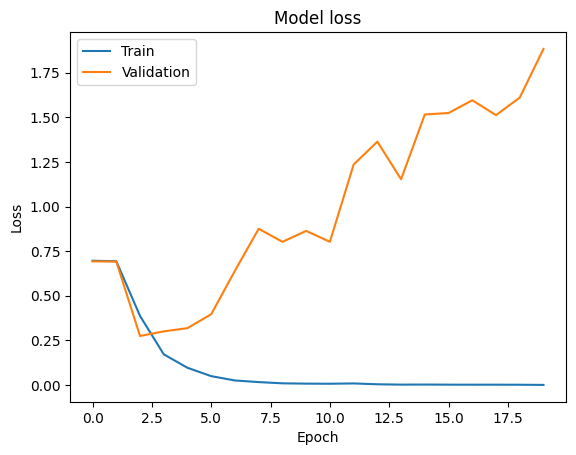

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()